In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from time import time
import statsmodels.api as sm
import requests

# meta parameters: 

FREQ = "1d" # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo 

In [64]:
def get_crypto_price(token, start, end):
    base_url = "https://api.kucoin.com"
    coin_pair = "-".join([token, "USDT"])
    frequency = "1day" 
    start_at = datetime.strptime(start, "%Y-%m-%d")
    start_at = int(datetime.timestamp(start_at))
    end_at = datetime.strptime(end, "%Y-%m-%d")
    end_at = int(datetime.timestamp(end_at))
    price_url = f"/api/v1/market/candles?type={frequency}&symbol={coin_pair}&startAt={start_at}&endAt={end_at}"
    price_dict = {}
    prices = requests.get(base_url+price_url).json()
    for item in prices['data']: 
        date_converted = datetime.fromtimestamp(int(item[0])).strftime("%Y-%m-%d")
        price_dict[date_converted] = item[1:7]
    colnames = ["open", "close", "high", "low", "volume", "amount"]
    colnames = [f"{token.lower()}_{x}" for x in colnames] 
    priceDF = pd.DataFrame(price_dict,index = colnames).T
    for col in colnames:
        priceDF[col] = priceDF[col].astype(float)

    #convert dates to datetime from object
    priceDF.index = pd.to_datetime(priceDF.index)

    #reverse dates
    priceDF = priceDF.iloc[::-1]
    return priceDF
    

def download_data(ticker:str, start:str , end:str, freq:str= "1d", asset:str = "equity") -> pd.DataFrame:
    if asset == "equity":
        if type(ticker) == str:
            data = yf.download(ticker, start = start, end = end, interval = freq, progress = False)
            data.columns = [(f"{ticker}_"+col).lower() for col in data.columns]
        else: 
            if len(ticker) > 1:
                data = [yf.download(t, 
                                    start = start, 
                                    end = end, 
                                    interval = freq, 
                                    progress = False
                                   ).rename(
                    columns = {x : f"{t}_{x}" for x in yf.download(t, start = start, end = end, interval = freq, progress = False).columns}
                ) for t in ticker]
                data = pd.concat(data, axis = 1)
                data.columns = [col.lower() for col in data.columns]
    elif asset == "crypto":
        data = get_crypto_price(token = ticker, start = start, end = end)
    return data

test = download_data("ETH", "2020-1-1", "2021-1-1", asset = "crypto")
test.to_csv("test.csv", encoding = "utf-8")
# get_btc_price("2017-1-1", "2018-1-1")
test

,eth_open,eth_close,eth_high,eth_low,eth_volume,eth_amount
2020-01-01,130.70,127.12,130.76,126.42,13948.826889,1.795975e+06
2020-01-02,127.14,134.32,135.00,125.95,22306.405437,2.930149e+06
2020-01-03,134.32,134.23,135.76,132.58,10255.001137,1.370945e+06
2020-01-04,134.23,135.38,138.12,134.21,15608.143145,2.125306e+06
2020-01-05,135.38,144.12,144.37,134.94,25685.201996,3.618404e+06
...,...,...,...,...,...,...
2020-12-27,684.94,730.42,747.97,681.61,55948.656787,4.056110e+07
2020-12-28,730.42,731.85,740.63,689.51,36742.771629,2.633565e+07
2020-12-29,732.07,752.03,758.55,717.00,35526.794945,2.618189e+07
2020-12-30,752.04,736.20,755.53,722.01,26027.795744,1.924398e+07


<AxesSubplot:>

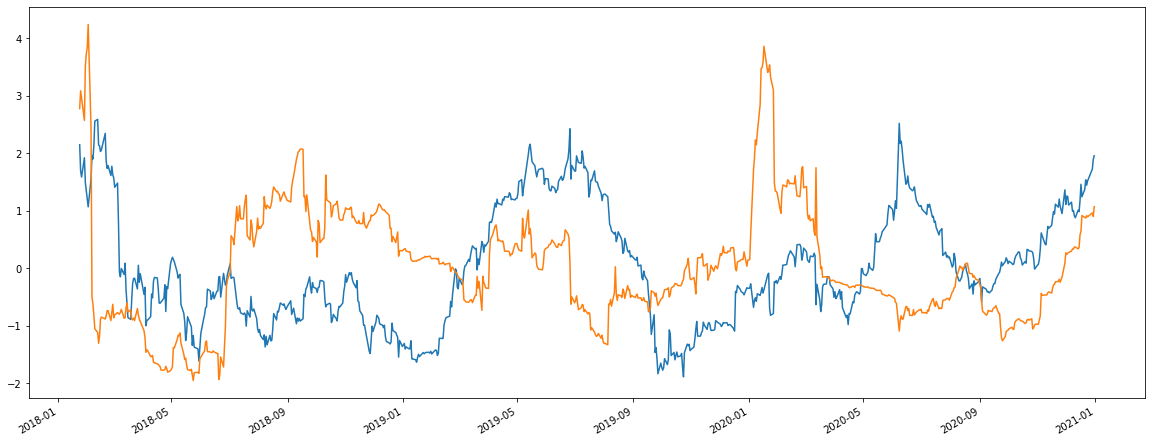

In [98]:
# WRITEME: write class for util_finance

class util_finance:
    def __init__(self, ticker, start, end): 
        self.ticker = ticker
        self.start = start 
        self.end = end
        self.data = download_data(ticker, start, end)
        self.o = self.data.loc[:,[col for col in self.data.columns if "_open" in col][0]]
        self.h = self.data.loc[:,[col for col in self.data.columns if "_high" in col][0]]
        self.c = self.data.loc[:,[col for col in self.data.columns if "_close" in col][0]]
        self.l = self.data.loc[:,[col for col in self.data.columns if "_low" in col][0]]
        self.adjc = self.data.loc[:,[col for col in self.data.columns if "adj close" in col][0]]
    
    # statistical functions:
    
    def logprice(self, close = "adjc"):
        return np.log(self.adjc)
        
    def ret(self, close = "adjc"):
        if close == "adjc":
            return self.adjc.pct_change()
        elif close == "c":
            return self.c.pct_change()
    
    def hh(self,lookback = 10):
        return self.h.rolling(lookback).max()
    
    def ll(self, lookback = 10):
        return self.l.rolling(lookback).min()
    
    def hl_ratio(self, lookback = 10):
        return self.hh(lookback)/self.ll(lookback)

    def geom_rolling_range(self, lookback = 10, roll_window = 10):
        hlr = self.hl_ratio(lookback) 
        return hlr / hlr.rolling(roll_window).mean()
    
    def macd(self, periods = (12,26,9)):
        adjc = self.adjc()
        k = adjc.ewm(span=periods[0], adjust=False, min_periods=periods[0]).mean()
        d = adjc.ewm(span=periods[1], adjust=False, min_periods=periods[1]).mean()
        macd = k - d
        macd_s = macd.ewm(span=periods[2], adjust=False, min_periods=periods[2]).mean()
        return macd - macd_s
    
    def vol_ohlc(self, lookback = 10):
        o = self.o
        h = self.h
        l = self.l
        c = self.c
        k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
        cc = np.log(c/c.shift(1))
        ho = np.log(h/o)
        lo = np.log(l/o)
        co = np.log(c/o)
        oc = np.log(o/c.shift(1))
        oc_sq = oc**2
        cc_sq = cc**2
        rs = ho*(ho-co)+lo*(lo-co)
        close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
        open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
        window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
        result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
        result[:lookback-1] = np.nan
        return result
        
    def mdd(self, lookback = 20):
        adjc = self.adjc
        roll_max = adjc.rolling(lookback).max()
        dd = adjc/roll_max - 1
        mdd = dd.rolling(lookback).min()
        return mdd
        
    def OLS(self, market = "SPY"): # global beta
        if market.lower() == "spy":
            mkt = download_data(market, self.start, self.end)
            mkt_adjc = mkt.loc[:,f"{market.lower()}_adj close"]
            mkt_ret = mkt_adjc.pct_change()
        elif market.lower() == "btc":
            mkt = download_data(market, self.start, self.end, asset = "crypto")
            mkt_c = mkt.loc[:,f"{market.lower()}_close"]
            mkt_ret = mkt_c.pct_change()
        y = mkt_ret.dropna(how = "any")
        X = self.ret().dropna(how = "any")
        shared_index = [d for d in y.index if d in X.index]

        X = X.loc[shared_index]
        y = y.loc[shared_index]
        X = sm.add_constant(X)

        model = sm.OLS(y, X)
        results = model.fit()
        return results
    
    def beta(self, market = "SPY"):
        return self.OLS(market = market).params[1]
    
    def alpha(self, market = "SPY"):
        return self.OLS(market = market).params[0]
    
    def tbeta(self, market = "SPY"):
        return self.OLS(market = market).tvalues[1]
    
    def talpha(self, market = "SPY"):
        return self.OLS(market = market).tvalues[0]
        
    def OLS_rolling(self, market = "SPY", lookback = 60):
        if market.lower() == "spy":
            mkt = download_data(market, self.start, self.end)
            mkt_adjc = mkt.loc[:,f"{market.lower()}_adj close"]
            mkt_ret = mkt_adjc.pct_change()
        elif market.lower() == "btc":
            mkt = download_data(market, self.start, self.end, asset = "crypto")
            mkt_c = mkt.loc[:,f"{market.lower()}_close"]
            mkt_ret = mkt_c.pct_change()
        def run(df):
            y = df.iloc[:,0]
            X = df.iloc[:,1:]
            X = sm.add_constant(X)
            model = sm.OLS(y.dropna(how = "any"), 
                           X.dropna(how = "any"))
            results = model.fit()
            return results
        y = mkt_ret.dropna(how = "any")
        X = self.ret().dropna(how = "any")
        shared_index = [d for d in y.index if d in X.index]
        X = X.loc[shared_index]
        y = y.loc[shared_index]
        X = sm.add_constant(X)
        df = pd.concat([y, X], axis = 1)
        out = pd.concat([ (pd.Series(run(df.iloc[i:i+lookback]), index=[df.index[i+lookback]])) for i in range(len(df)-lookback) ])
        # df.rolling(lookback).apply(lambda x : run(x.iloc[:,0], x.iloc[:,1:]), axis = 1)
        return out

    def beta_rolling(self, market = "SPY", lookback = 60):
        return self.OLS_rolling(market, lookback).apply(lambda x : x.params[1])
    
    def alpha_rolling(self, market = "SPY", lookback = 60):
        return self.OLS_rolling(market, lookback).apply(lambda x : x.params[0])
    
    def tbeta_rolling(self, market = "SPY", lookback = 60):
        return self.OLS_rolling(market, lookback).apply(lambda x : x.tvalues[1])
    
    def talpha_rolling(self, market = "SPY", lookback = 60):
        return self.OLS_rolling(market, lookback).apply(lambda x : x.tvalues[0])
    
    def event_beta(self, market = "SPY", lookback = 60, mult = 3):
        diff = self.beta_rolling().diff()
        upper = diff.mean() + mult * diff.std()
        lower = diff.mean() - mult * diff.std()
        return 0 + (diff > upper) * 1 - (diff < lower) * 1
    
    def init_ax(self, dim = (1,1), figsize = [20,8]):
        self.graph, self.ax = plt.subplots(dim[0],dim[1], figsize = figsize)
        return self.ax
        
    
    

uf = util_finance("SPY", "2017-01-01", "2021-01-01")

fig, ax = plt.subplots(1,1, figsize = [20, 8]) 
# uf.alpha_rolling().plot()
# (uf.event_beta() == -1).sum()

# uf.event_beta().plot()
# uf.init_ax()
from util_data import scale
scale(uf.alpha_rolling(market = "BTC")).plot()
scale(uf.beta_rolling(market = "BTC")).plot()



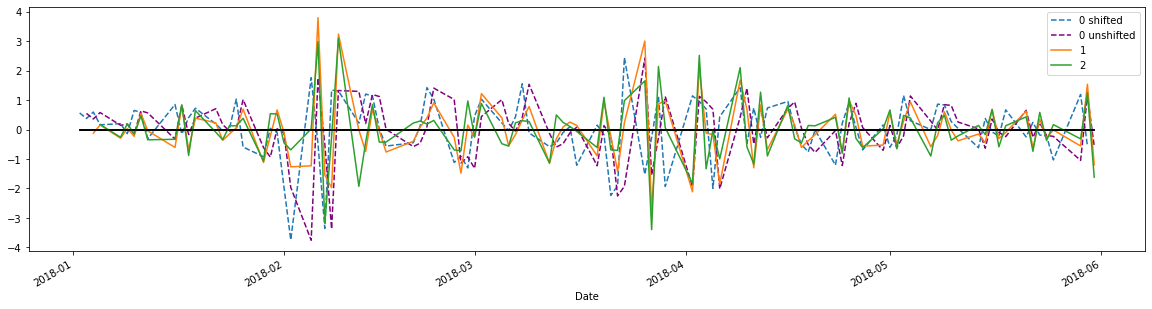

In [21]:
n = 3
plt.figure(figsize = [20, 5])
uf = util_finance("SPY", "2018-01-01", "2018-06-01")
obj = uf.ret()
for i in range(n):
    if i == 0:
        ((obj )/obj.std()).shift(-1).plot(label = "0 shifted", linestyle = "--")
        ((obj - obj.mean())/obj.std()).plot(label = "0 unshifted", color = "purple", linestyle = "--")
    else:
        ((obj - obj.mean())/obj.std()).plot(label = i)
    
    plt.legend()
    plt.plot(obj.index, [0]*len(obj.index), color = "black", linestyle = "-")
    obj = obj.diff()

does
this
work?


In [101]:
list(range(10,1,-1))

[10, 9, 8, 7, 6, 5, 4, 3, 2]

In [104]:
list(reversed(range(1,11)))

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]